# **Project 1: Sentiment Analysis**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/LDS10_Project_TranMinhTien/Project_1'

/content/gdrive/MyDrive/LDS10_Project_TranMinhTien/Project_1


In [3]:
import pandas as pd
import numpy as np
!pip install underthesea
!pip install demoji
!pip install pyvi
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer
import string
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 43.5 MB/s eta 0:00:00


# 1.Nhập dữ liệu

In [4]:
data_hotel_profiles = pd.read_csv('hotel_profiles.csv')
data_hotel_profiles.head(3)

,num,Hotel ID,Hotel Name,Hotel Rank,Hotel Address,Total Score,Vị trí,Độ sạch sẽ,Dịch vụ,Tiện nghi,Đáng giá tiền,Sự thoải mái và chất lượng phòng
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5 sao trên 5,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3"
1,2,1_2,ALPHA BIRD NHA TRANG,4 sao trên 5,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...","7,7","7,8","7,6","8,1","7,5","8,1",NaN
2,3,1_3,Khách sạn Aaron (Aaron Hotel),3.5 sao trên 5,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...","8,5","8,9","8,7","8,8","8,1","8,5",NaN


In [5]:
data_hotel_comments = pd.read_csv('hotel_comments.csv')
data_hotel_comments.head(3)

,num,Hotel ID,Reviewer ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",Đã nhận xét vào 25 tháng 6 2024


# 2.Tiền xử lý dữ liệu:

## a. Chuẩn bị cho tiền xử lý:

In [6]:
##LOAD EMOJICON
file = open('emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [7]:
def process_text(text, emoji_dict, teen_dict, wrong_lst):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        # ...
        ###### DEL wrong words
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '
    document = new_sentence
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    #...
    return document

In [8]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [9]:
def process_special_word(text):
    # có thể có nhiều từ đặc biệt cần ráp lại với nhau
    new_text = ''
    text_lst = text.split()
    i= 0
    # không, chẳng, chả...
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [10]:
import re
# Hàm để chuẩn hóa các từ có ký tự lặp
def normalize_repeated_characters(text):
    # Thay thế mọi ký tự lặp liên tiếp bằng một ký tự đó
    # Ví dụ: "lònggggg" thành "lòng", "thiệtttt" thành "thiệt"
    return re.sub(r'(.)\1+', r'\1', text)

In [11]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['N','Np','A','AB','V','VB','VY','R']
        # lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [12]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [13]:
positive_words = [
    "thích", "tốt", "xuất sắc", "tuyệt vời", "tuyệt hảo", "đẹp", "ổn", "ngon",
    "hài lòng", "ưng ý", "hoàn hảo", "chất lượng", "thú vị", "nhanh", "miễn phí"
    "tiện lợi", "dễ sử dụng", "hiệu quả", "ấn tượng", "nhẹ nhàng", "ghé lại lần tới",
    "nổi bật", "tận hưởng", "tốn ít thời gian", "thân thiện", "hấp dẫn", "khuyến khích",
    "cao cấp", "độc đáo", "rất tốt", "rất thích", "tận tâm", "đáng tin cậy", "đẳng cấp", "sang trọng",
    "hấp dẫn", "an tâm", "thúc đẩy", "cảm động", "phục vụ tốt", "làm hài lòng", "gây ấn tượng", "nổi trội",
    "sáng tạo", "phù hợp", "tận tâm", "hiếm có", "cải thiện", "hoà nhã", "chăm chỉ", "cẩn thận",
    "vui vẻ", "sáng sủa", "hào hứng", "đam mê", "vừa vặn", "đáng tiền", "sạch sẽ", "đẹp", "tiện",
    "nhiệt tình", "rộng rãi", "rẻ", "thuận tiện", "hợp lý", "đầy đủ", "yên tĩnh", "thoải mái", "gần", "đáng tiền",
    "nhộn nhịp", "sầm uất", "phải chăng", "gọn gàng", "ok", "lịch sự", "dễ", "thoáng", "rộng",
]

In [14]:
negative_words = [
    "kém", "tệ", "buồn", "chán", "yếu", "hư", "kẹt", "chê", "mùi", "cũ", "nhỏ", "nên",
    "kém chất lượng", "không thích", "không ổn", "không tốt", "không hài lòng", "khó chịu",
    "không hợp", "không đáng tin cậy", "không chuyên nghiệp", "bẩn", "rác", "kì cục", "ghét",
    "không phản hồi", "không an toàn", "không phù hợp", "không thân thiện", "không linh hoạt", "không đáng giá",
    "không ấn tượng", "không tốt", "chậm", "khó khăn", "phức tạp", "khó khăn", "lâu", "chém", "không được",
    "khó chịu", "gây khó dễ", "rườm rà", "thất bại", "tồi tệ", "khó xử", "không thể chấp nhận", "tồi tệ","không rõ ràng",
    "không chắc chắn", "rối rắm", "không tiện lợi", "không đáng tiền", "chưa đẹp", "không đẹp", "dở tệ",
    'tồi', 'xấu', 'không hài lòng', 'bẩn', 'khó chịu', 'không sạch sẽ', 'không thoải mái', 'không đáng', 'quá tệ', 'rất tệ',
    'thất vọng', 'chán', 'tệ hại', 'kinh khủng', 'khủng khiếp', 'không ưng ý', "giá cao", "nóng", "chật", "xa",
    "không thân thiện", "mắc", "tối", "ẩm mốc", "vắng", "muỗi", "hạn chế", "hôi", "nguội", "chậm", "hẹp"
]

In [15]:
def find_words(document, list_of_words):
    document_lower = document.lower()
    word_count = 0
    word_list = []

    for word in list_of_words:
        if word in document_lower:
            print(word)
            word_count += document_lower.count(word)
            word_list.append(word)

    return word_count, word_list

In [16]:
# Count emojis positive and negative
negative_emojis = [
    "😞", "😔", "🙁", "☹️", "😕",
    "😢", "😭", "😖", "😣", "😩",
    "😠", "😡", "🤬", "😤", "😰",
    "😨", "😱", "😪", "😓", "🥺",
    "😒", "🙄", "😑", "😬", "😶",
    "🤯", "😳", "🤢", "🤮", "🤕",
    "🥴", "🤔", "😷", "🙅‍♂️", "🙅‍♀️",
    "🙆‍♂️", "🙆‍♀️", "🙇‍♂️", "🙇‍♀️", "🤦‍♂️",
    "🤦‍♀️", "🤷‍♂️", "🤷‍♀️", "🤢", "🤧",
    "🤨", "🤫", "👎", "👊", "✊", "🤛", "🤜",
    "🤚", "🖕"
]

In [17]:
positive_emojis = [
    "😄", "😃", "😀", "😁", "😆",
    "😅", "🤣", "😂", "🙂", "🙃",
    "😉", "😊", "😇", "🥰", "😍",
    "🤩", "😘", "😗", "😚", "😙",
    "😋", "😛", "😜", "🤪", "😝",
    "🤗", "🤭", "🥳", "😌", "😎",
    "🤓", "🧐", "👍", "🤝", "🙌", "👏", "👋",
    "🤙", "✋", "🖐️", "👌", "🤞",
    "✌️", "🤟", "👈", "👉", "👆",
    "👇", "☝️", "💚"
]

## b. Tiền xử lý dữ liệu thông tin khách sạn:

In [18]:
data_hotel_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   num                               1290 non-null   int64 
 1   Hotel ID                          1290 non-null   object
 2   Hotel Name                        1290 non-null   object
 3   Hotel Rank                        1290 non-null   object
 4   Hotel Address                     1290 non-null   object
 5   Total Score                       1290 non-null   object
 6   Vị trí                            638 non-null    object
 7   Độ sạch sẽ                        635 non-null    object
 8   Dịch vụ                           548 non-null    object
 9   Tiện nghi                         540 non-null    object
 10  Đáng giá tiền                     630 non-null    object
 11  Sự thoải mái và chất lượng phòng  66 non-null     object
dtypes: int64(1), object(

In [19]:
# Do cột Sự thoải mái và chất lượng phòng có quá ít giá trị nên xóa cột
data_hotel_profiles.drop(columns=['Sự thoải mái và chất lượng phòng'], inplace=True)

In [20]:
# Tìm các hàng có chứa 'No information'
rows_with_no_info = data_hotel_profiles[data_hotel_profiles.isin(['No information']).any(axis=1)]

# Thay thế 'No information' bằng NaN
data_hotel_profiles.replace('No information', np.nan, inplace=True)

# Chọn các cột numeric để xóa các dòng mà các cột này chứa giá trị nan, danh sách các cột cần kiểm tra
columns_to_check = ['Total Score', 'Vị trí', 'Độ sạch sẽ', 'Dịch vụ', 'Tiện nghi', 'Đáng giá tiền']

# Xóa các dòng mà tất cả các cột đều là NaN
data_hotel_profiles = data_hotel_profiles.dropna(subset=columns_to_check, how='all')

In [21]:
# Chuyển đổi các cột numeric đang ở dạng object
# Chọn các cột cần chuyển đổi
columns_to_convert = ['Total Score', 'Vị trí', 'Độ sạch sẽ', 'Dịch vụ', 'Tiện nghi', 'Đáng giá tiền']

for column in columns_to_convert:
    # Thay thế dấu phẩy bằng dấu chấm, loại bỏ khoảng trắng và các ký tự không phải số
    data_hotel_profiles[column] = data_hotel_profiles[column].str.replace(',', '.').str.strip()
    data_hotel_profiles[column] = pd.to_numeric(data_hotel_profiles[column], errors='coerce')

In [22]:
data_hotel_profiles[data_hotel_profiles['Total Score'].isnull()]

,num,Hotel ID,Hotel Name,Hotel Rank,Hotel Address,Total Score,Vị trí,Độ sạch sẽ,Dịch vụ,Tiện nghi,Đáng giá tiền
791,792,27_12,Vanda Hotel Nha Trang,NaN,"26/4 Trần Phú, phường Vĩnh Nguyên, TP. Nha Tra...",NaN,8.3,8.0,8.5,7.9,8.5


In [23]:
# Điền giá trị nan cho cột Total Score
def fill_total_score(row):
    if pd.isnull(row['Total Score']):
        # Lấy giá trị của các cột cần tính trung bình
        columns_to_average = ['Vị trí', 'Độ sạch sẽ', 'Dịch vụ', 'Tiện nghi', 'Đáng giá tiền']
        values = row[columns_to_average]

        # Tính trung bình của các giá trị không null
        mean_value = values.mean()

        return mean_value
    else:
        return row['Total Score']

# Áp dụng hàm fill_total_score cho mỗi hàng của DataFrame
data_hotel_profiles['Total Score'] = data_hotel_profiles.apply(fill_total_score, axis=1)

In [24]:
# Xử lý cột Hotel Rank về dạng nummeric
data_hotel_profiles['Hotel Rank'].unique()

array(['5 sao trên 5', '4 sao trên 5', '3.5 sao trên 5', '3 sao trên 5',
       '4.5 sao trên 5', '2.5 sao trên 5', '2 sao trên 5', nan,
       '1 sao trên 5', '1.5 sao trên 5'], dtype=object)

In [25]:
# Hàm chuyển đổi văn bản thành số
def convert_rank_to_numeric(rank):
    if pd.isna(rank):
        return np.nan
    try:
        # Tách số sao từ chuỗi văn bản
        return float(rank.split(' ')[0])
    except:
        return np.nan

# Áp dụng hàm chuyển đổi cho cột 'Hotel Rank'
data_hotel_profiles['Hotel Rank'] = data_hotel_profiles['Hotel Rank'].apply(convert_rank_to_numeric)

In [26]:
# Dùng Hồi quy Tuyến tính để dừ đoạn các dòng mà Hotel Rank bị nan từ cột Total Score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Giả sử df là DataFrame của bạn và bạn muốn điền giá trị thiếu trong cột 'Total Score'
df = data_hotel_profiles

# Chọn các cột làm feature và target
features = ['Total Score']  # Ví dụ, bạn có thể chọn nhiều cột khác nhau
target = 'Hotel Rank'

# Tách dữ liệu thành tập huấn luyện và tập kiểm tra (với các hàng không thiếu giá trị)
df_train = data_hotel_profiles.dropna(subset=[target])
X_train = df_train[features]
y_train = df_train[target]

# Khởi tạo và huấn luyện mô hình
model = LinearRegression()
model.fit(X_train, y_train)

# Tách các hàng có giá trị thiếu trong cột mục tiêu
df_null = data_hotel_profiles[data_hotel_profiles[target].isna()]

# Đảm bảo rằng df_null có dữ liệu để dự đoán
if not df_null.empty:
    X_null = df_null[features]
    # Dự đoán các giá trị null
    df_null[target] = model.predict(X_null)

    # Điền giá trị dự đoán vào DataFrame gốc
    data_hotel_profiles.update(df_null)

In [27]:
data_hotel_profiles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 644 entries, 0 to 1289
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num            644 non-null    int64  
 1   Hotel ID       644 non-null    object 
 2   Hotel Name     644 non-null    object 
 3   Hotel Rank     644 non-null    float64
 4   Hotel Address  644 non-null    object 
 5   Total Score    644 non-null    float64
 6   Vị trí         638 non-null    float64
 7   Độ sạch sẽ     635 non-null    float64
 8   Dịch vụ        548 non-null    float64
 9   Tiện nghi      540 non-null    float64
 10  Đáng giá tiền  630 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 60.4+ KB


Nhận xét: Việc điền xử lý dữ liệu null đã xong. Các cột điểm như vị trí, độ sạch sẽ, dịch vụ, tiện nghi và đáng giá tiền không có nhiều ý nghĩa thống kê bởi vì các cột này đã được tính trung bình ở cột Total score. Nên các cột này không nhất thiết phải điền đủ.

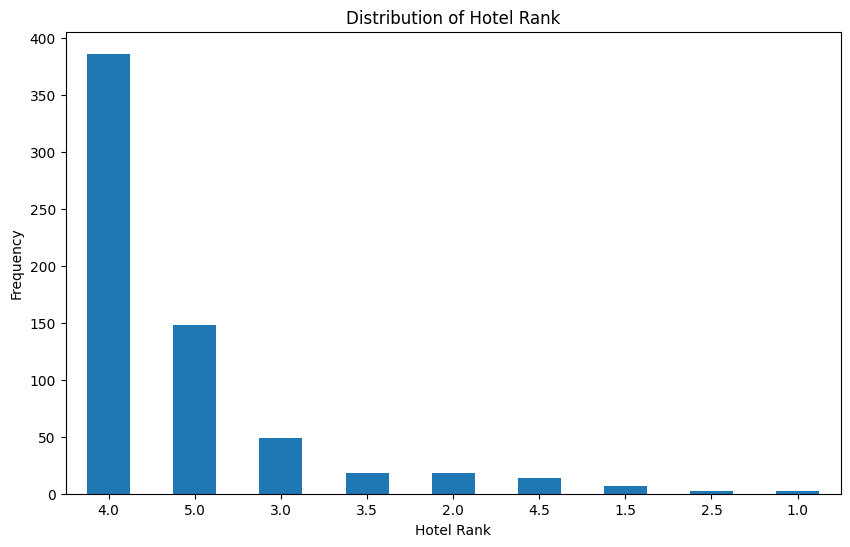

In [28]:
import matplotlib.pyplot as plt

# Làm tròn các giá trị trong cột Hotel Rank về số thập phân thứ nhất
data_hotel_profiles['Hotel Rank'] = data_hotel_profiles['Hotel Rank'].round(1)
data_hotel_profiles['Hotel Rank'] = data_hotel_profiles['Hotel Rank'].replace(4.1, 4)
# Đếm số lượng mỗi hạng mục
rank_counts = data_hotel_profiles['Hotel Rank'].value_counts()
# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
rank_counts.plot(kind='bar')
plt.xlabel('Hotel Rank')
plt.ylabel('Frequency')
plt.title('Distribution of Hotel Rank')
plt.xticks(rotation=0)
plt.show()

Nhận xét: Hạng của mỗi khách sạn ứng với mỗi khách sạn duy nhất, dữ liệu này chấp nhận mất cân bằng, không thể tạo thêm khách sạn với các hạng khách sạn thấp được, trường hợp xóa bớt các khách sạn có hạng cao để cân bằng với số khách sạn có hạng thấp sẽ làm cho số lượng data giảm đáng kể.

## c. Tiền xử lý tiếng Việt dữ liệu bình luận:

In [29]:
data_hotel_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80314 entries, 0 to 80313
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   num            80314 non-null  int64 
 1   Hotel ID       80314 non-null  object
 2   Reviewer ID    80314 non-null  object
 3   Reviewer Name  80228 non-null  object
 4   Nationality    80314 non-null  object
 5   Group Name     80314 non-null  object
 6   Room Type      80314 non-null  object
 7   Stay Details   80314 non-null  object
 8   Score          80314 non-null  object
 9   Score Level    80314 non-null  object
 10  Title          80314 non-null  object
 11  Body           80272 non-null  object
 12  Review Date    80314 non-null  object
dtypes: int64(1), object(12)
memory usage: 8.0+ MB


In [30]:
data_hotel_comments.head(3)

,num,Hotel ID,Reviewer ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",Đã nhận xét vào 25 tháng 6 2024


In [31]:
# Xóa cột Reviewer Name
data_hotel_comments = data_hotel_comments.drop(columns=['Reviewer Name', 'Reviewer ID'])

# Xóa các dòng có giá trị null trong cột Body
data_hotel_comments = data_hotel_comments.dropna(subset=['Body'])

In [32]:
# Xử lý cột Review Date về dạng ngày tháng năm
from datetime import datetime

# Hàm chuyển đổi chuỗi ngày tháng sang định dạng ngày tháng
def parse_review_date(date_str):
    # Bỏ phần "Đã nhận xét vào" và tách ngày, tháng, năm
    date_str = date_str.replace('Đã nhận xét vào ', '')
    date_parts = date_str.split(' tháng ')
    day = date_parts[0]
    month_year = date_parts[1]
    month, year = month_year.split(' ')

    # Chuyển đổi tháng từ chữ sang số
    month_map = {
        'tháng 1': '01', 'tháng 2': '02', 'tháng 3': '03',
        'tháng 4': '04', 'tháng 5': '05', 'tháng 6': '06',
        'tháng 7': '07', 'tháng 8': '08', 'tháng 9': '09',
        'tháng 10': '10', 'tháng 11': '11', 'tháng 12': '12'
    }

    month = month_map['tháng ' + month]

    # Định dạng ngày tháng theo định dạng ngày/tháng/năm
    formatted_date = f"{day}/{month}/{year}"
    return formatted_date

# Áp dụng hàm parse_review_date vào cột Review Date
data_hotel_comments['Review Date'] = data_hotel_comments['Review Date'].apply(parse_review_date)

In [33]:
# Xóa các dòng trùng lặp dựa trên các cột 'Hotel ID', 'Score'
data_hotel_comments.drop_duplicates(subset=['Hotel ID', 'Score'], inplace=True)

In [34]:
# Xóa các dòng ở cột Body không phải tiếng Việt
!pip install langdetect
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
DetectorFactory.seed = 0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=4f4ee2c2e0b594c6634fce57e464744e77c3adcdb7f50a4246397311fcc998d2
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [35]:
def is_vietnamese(text):
    try:
        return detect(text) == 'vi'
    except LangDetectException:
        return False

data_hotel_comments['is_vietnamese'] = data_hotel_comments['Body'].apply(is_vietnamese)
data_hotel_comments = data_hotel_comments[data_hotel_comments['is_vietnamese']]
data_hotel_comments = data_hotel_comments.drop(columns=['is_vietnamese'])

In [36]:
# Áp dụng các hàm xử lý cho cột Body của dataframe
data_hotel_comments['Body'] = data_hotel_comments['Body'].apply(covert_unicode)
data_hotel_comments['Body'] = data_hotel_comments['Body'].apply(normalize_repeated_characters)
data_hotel_comments['Body'] = data_hotel_comments['Body'].apply(process_special_word)
data_hotel_comments['Body'] = data_hotel_comments['Body'].apply(lambda text: process_text(text, emoji_dict, teen_dict, wrong_lst))

In [37]:
# Hiển thị các từ có tần suất xuát hiện cao trong cột Body
from collections import Counter
# Kết hợp tất cả các văn bản trong cột Body thành một chuỗi
all_text = ' '.join(data_hotel_comments['Body'])

# Phân tách từ bằng pyvi
words = ViTokenizer.tokenize(all_text).split()

# Đếm tần suất xuất hiện của các từ
word_counts = Counter(words)

# Lấy 100 từ có tần suất xuất hiện cao nhất
top_words = word_counts.most_common(100)
top_words

[('.', 6499),
 ('phòng', 2007),
 ('và', 1797),
 ('có', 1668),
 ('rất', 1361),
 ('khách_sạn', 1237),
 ('ở', 975),
 ('là', 972),
 ('mình', 889),
 ('tôi', 876),
 ('nhân_viên', 875),
 ('nhưng', 822),
 ('không', 763),
 ('biển', 756),
 ('được', 680),
 ('đi', 669),
 ('nên', 661),
 ('thì', 652),
 ('sạch_sẽ', 638),
 ('với', 621),
 ('cũng', 601),
 ('cho', 587),
 ('tốt', 582),
 ('lại', 540),
 ('ăn', 526),
 ('đẹp', 518),
 ('sáng', 503),
 ('để', 478),
 ('của', 448),
 ('hơi', 444),
 ('khách', 444),
 ('đến', 443),
 ('nhiều', 436),
 ('đã', 435),
 ('các', 419),
 ('giá', 418),
 ('sẽ', 410),
 ('bạn', 395),
 ('khá', 395),
 ('một', 390),
 ('gần', 389),
 ('nhiệt_tình', 372),
 ('đây', 370),
 ('vị_trí', 361),
 ('chỉ', 346),
 ('thân_thiện', 344),
 ('tiện', 334),
 ('tâm', 328),
 ('này', 325),
 ('cảnh', 315),
 ('vào', 308),
 ('người', 305),
 ('vì', 297),
 ('như', 275),
 ('bãi', 263),
 ('hơn', 263),
 ('phải', 260),
 ('mới', 258),
 ('nếu', 257),
 ('bơi', 256),
 ('đó', 256),
 ('lần', 253),
 ('nhỏ', 253),
 ('đồ', 25

In [38]:
# Hàm đếm số từ tích cực và tiêu cực
def count_words(text, words):
    text = text.lower()
    words_in_text = re.findall(r'\b\w+\b', text)
    count = sum(1 for word in words_in_text if word in words)
    return count

# Tạo cột mới để đếm số từ tích cực và tiêu cực
data_hotel_comments['Positive Words Count'] = data_hotel_comments['Body'].apply(lambda x: count_words(x, positive_words))
data_hotel_comments['Negative Words Count'] = data_hotel_comments['Body'].apply(lambda x: count_words(x, negative_words))

# Tạo cột điểm số (số từ tích cực - số từ tiêu cực)
data_hotel_comments['Score'] = data_hotel_comments['Positive Words Count'] - data_hotel_comments['Negative Words Count']

In [39]:
# Hàm xác định sentiment dựa trên score
def determine_sentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

# Áp dụng hàm xác định sentiment cho cột 'Score'
data_hotel_comments['Sentiment'] = data_hotel_comments['Score'].apply(determine_sentiment)

In [40]:
sentiment_counts = data_hotel_comments['Sentiment'].value_counts()
sentiment_counts

,count
Sentiment,
positive,1051
neutral,554
negative,438


In [41]:
# Lọc các dòng có Sentiment là 'Trung tính'
neutral_comments = data_hotel_comments[data_hotel_comments['Sentiment'] == 'neutral']

# Hiển thị giá trị của cột Body
print(neutral_comments['Body'].tolist())

['hôm đi đến lúc về thì mọi thứ khách sạn điều tuyết vời nhân viên đón tiép nhiệt tình tiện đầy đủ. có trường hợp bữa đi lịch ở khách sạn thì dụng cụ phòng tắm bữa đầu điều có đầy đủ nhưng ngày và ngày bỏ thêm dụng cụ cho những ngày đó. nên chỉ có ý kiến ở vấn đề này. cảm ơn nhân viên và khách sạn đã phục vụ nhiệt tình cho khách đi lịch tại .', 'khách sạn ở vị trí tâm nhân viên phục vụ nhiệt tình phòng rộng rãi sạch sẽ điểm trừ máy hơi chậm có khóa không hoạt động nhiên rất đáng với giá tiền bỏ nếu lại mình cũng sẽ lựa chọn ở đây lần nữa.', 'hài lòng với giá tiền.', 'mình đặt phòng thường tới nơi được nâng cấp lên phòng công bồn tắm mà giá phòng sạch sẽ cách âm bình thường xứng đáng với giá tiền.', 'cảm thấy bất ngờ với chất lượng với mức giá này phòng ốc đẹp dịch vụ chăn gối tạm chấp nhận được có vài vết bẩn thì là phía nhà giặt xử lí thôi chứ vẫn thơm nhân viên nhiệt tình đón tiếp và hỗ trợ khách hàng. khách sạn hỗ trợ cho khách nhận phòng sớm trở đi yêu.', 'phòng thoáng nhưng hơi cũ

# 3.Trực quan hóa tìm hiểu dữ liệu

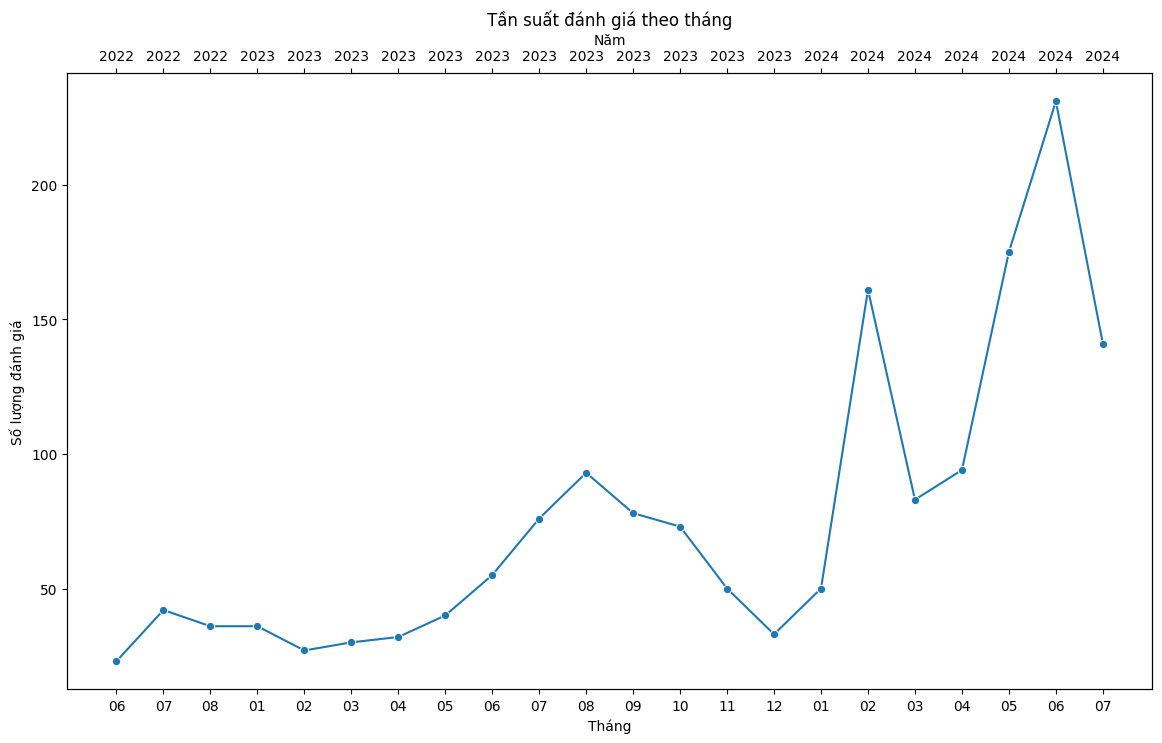

In [42]:
# Chuyển đổi cột 'Review Date' thành datetime với định dạng ngày/tháng/năm
# data_hotel_comments['Review Date'] = pd.to_datetime(data_hotel_comments['Review Date'], format='%d/%m/%Y')
monthly_counts = pd.to_datetime(data_hotel_comments['Review Date'], format='%d/%m/%Y').dt.to_period('M').value_counts().sort_index()
monthly_counts = monthly_counts[monthly_counts > 20]
import seaborn as sns
# Tạo biểu đồ tần suất của các đánh giá theo tháng
plt.figure(figsize=(14, 8))

# Vẽ biểu đồ chính
sns.lineplot(x=monthly_counts.index.astype(str), y=monthly_counts.values, marker='o')
plt.title('Tần suất đánh giá theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng đánh giá')

# Đặt trục x
ax = plt.gca()
ax.set_xticks(range(len(monthly_counts.index)))
ax.set_xticklabels([date.strftime('%m') for date in monthly_counts.index.to_timestamp()], rotation=0, ha='center')

# Thêm hàng năm phía dưới trục x
years = [date.year for date in monthly_counts.index.to_timestamp()]
unique_years = sorted(set(years))
year_labels = [''] * len(years)
for year in unique_years:
    indices = [i for i, x in enumerate(years) if x == year]
    for index in indices:
        year_labels[index] = str(year)

# Thêm dòng năm phía dưới
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(year_labels, rotation=0, ha='center')
ax2.set_xlabel('Năm')

plt.show()

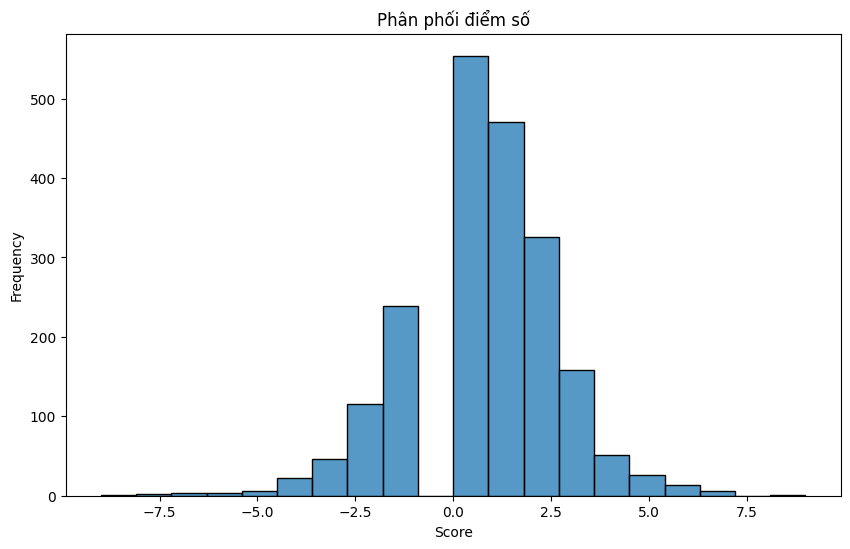

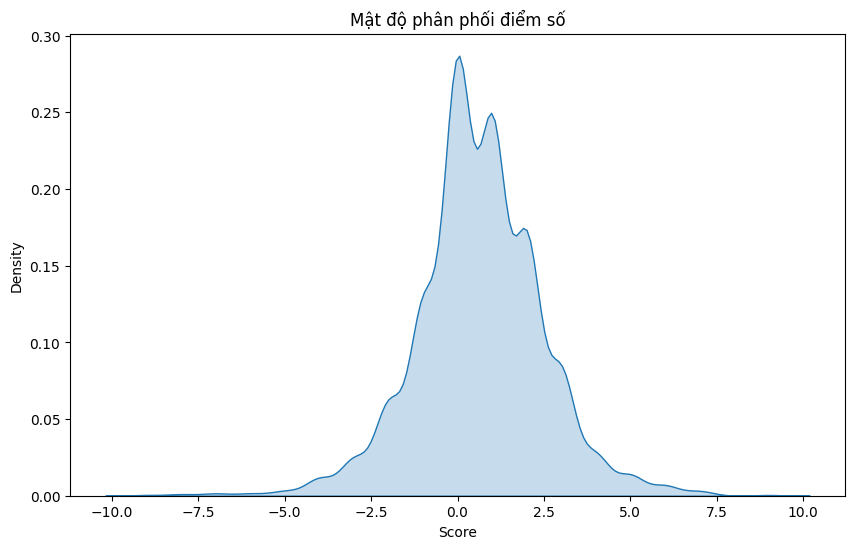

In [43]:
# Tạo biểu đồ histogram cho điểm số
plt.figure(figsize=(10, 6))
sns.histplot(data_hotel_comments['Score'], bins=20, kde=False)
plt.title('Phân phối điểm số')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Tạo biểu đồ mật độ (density plot) cho điểm số
plt.figure(figsize=(10, 6))
sns.kdeplot(data_hotel_comments['Score'], shade=True)
plt.title('Mật độ phân phối điểm số')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()


       Nationality     Score
0    Bắc Macedonia  0.750000
1        Campuchia  1.000000
2           Canada  0.250000
3           Hoa Kỳ  1.500000
4          Hungary  0.000000
5         Hàn Quốc  2.058824
6        Hồng Kông  2.200000
7        Indonesia  4.000000
8          Ireland  4.000000
9            Na Uy  0.000000
10             Nga  2.250000
11        Nhật Bản  1.777778
12     Philippines  1.000000
13            Pháp -4.000000
14       Singapore  1.000000
15        Thái Lan  2.571429
16      Trung Quốc  1.333333
17        Việt Nam  0.498914
18  Vương quốc Anh  1.000000
19              Úc  0.800000
20        Đan Mạch  2.000000
21        Đài Loan -0.750000
22           Ấn Độ  3.500000


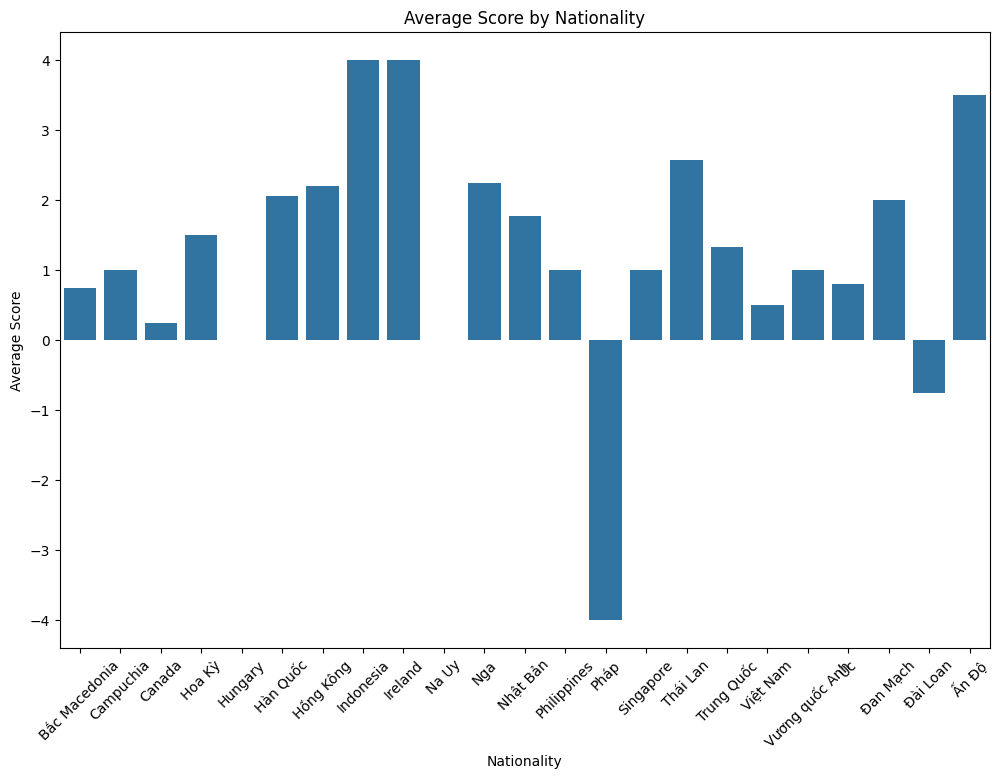

In [78]:
# Tính điểm trung bình Score theo quốc gia
avg_score_by_nationality = data_hotel_comments.groupby('Nationality')['Score'].mean().reset_index()

# Hiển thị kết quả
print(avg_score_by_nationality)

# Vẽ biểu đồ điểm trung bình Score theo quốc gia
plt.figure(figsize=(12, 8))
sns.barplot(data=avg_score_by_nationality, x='Nationality', y='Score')
plt.title('Average Score by Nationality')
plt.xlabel('Nationality')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()


Điểm trung bình cho thấy mức độ hài lòng của du khách, qua biểu đồ cho thấy du khách đến từ Ấn Độ, Indonesia và Ireland là có mức độ hài lòng cao nhất, họ là những du khách dễ tính nhất, còn du khách đến từ Pháp là có mức độ hài lòng thấp nhất.

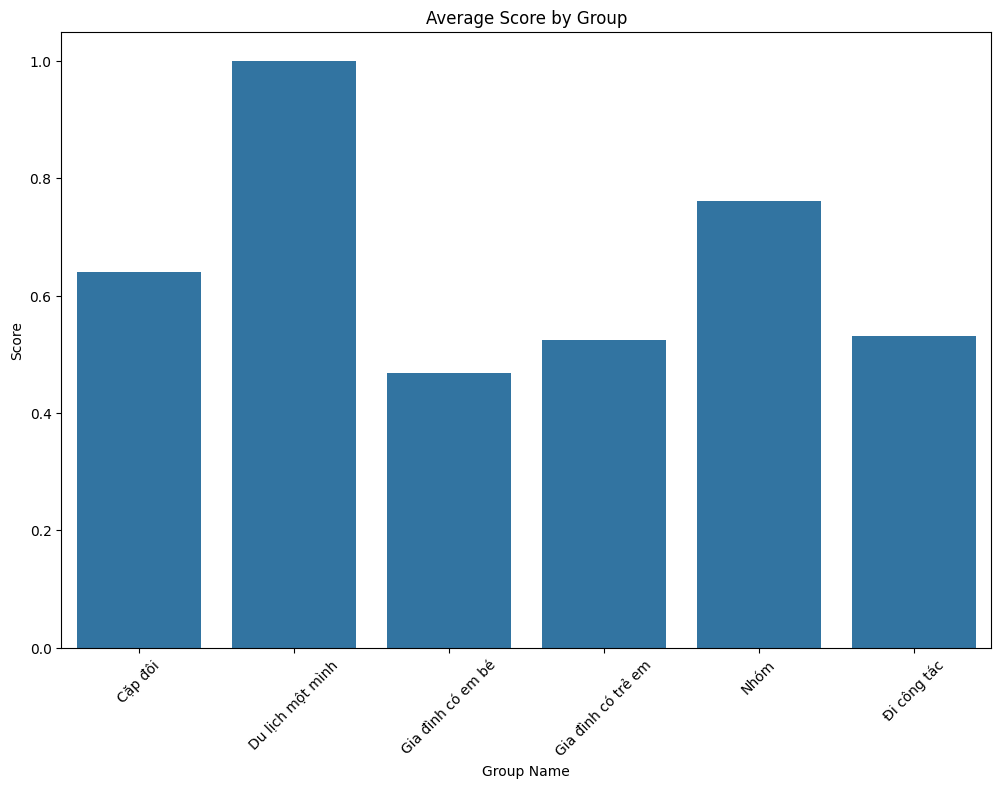

In [71]:
# Calculate average score by group name
avg_score_by_group = data_hotel_comments.groupby('Group Name')['Score'].mean().reset_index()

# Plot the average score by group name
plt.figure(figsize=(12, 8))
sns.barplot(data=avg_score_by_group, x='Group Name', y='Score')
plt.title('Average Score by Group')
plt.xticks(rotation=45)
plt.show()

Các du khách thường đi 1 mình là thường dế chịu nhất, sau đó đến đi theo nhóm, và gia đình có em bé và trẻ em là ít nhất, có thể việc du lịch có em bé và trẻ em khiến cho việc du lịch không thoải mái nên dễ có trải nghiệm không tốt ở khách hàng.

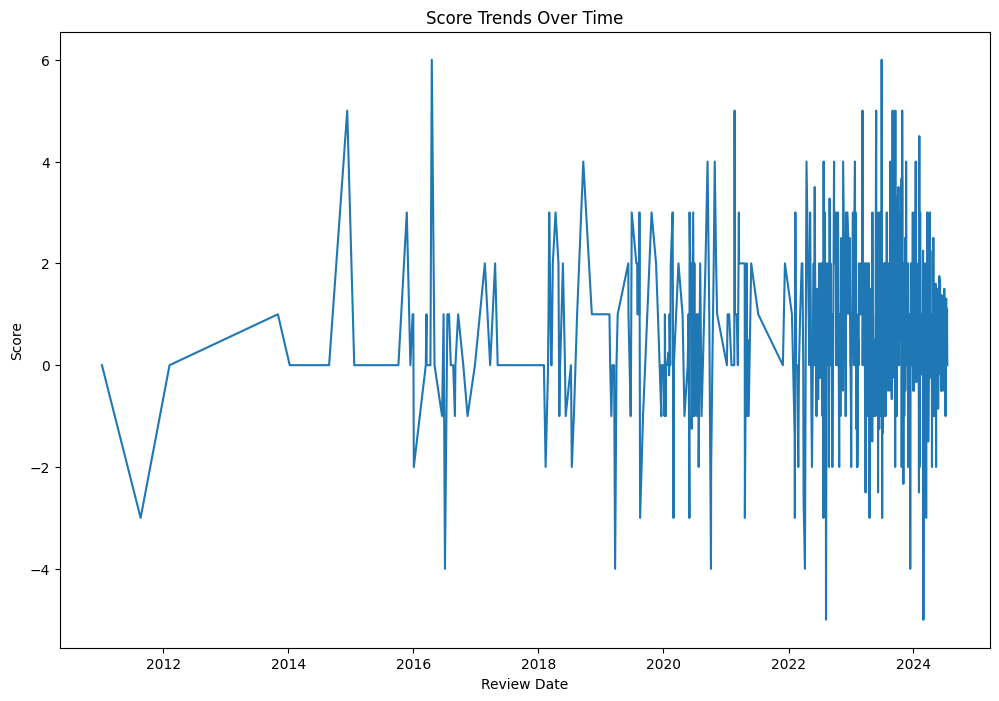

In [74]:
# Convert 'Review Date' to datetime format
data_hotel_comments['Review Date'] = pd.to_datetime(data_hotel_comments['Review Date'], format='%d/%m/%Y')

# Calculate average score by review date
avg_score_by_date = data_hotel_comments.groupby('Review Date')['Score'].mean().reset_index()

# Plot the score trend over time
plt.figure(figsize=(12, 8))
sns.lineplot(data=avg_score_by_date, x='Review Date', y='Score')
plt.title('Score Trends Over Time')
plt.show()

Điểm số theo thời gian không mấy cải thiện, cảm nhận cả khách hàng không thay đổi nhiều năm.

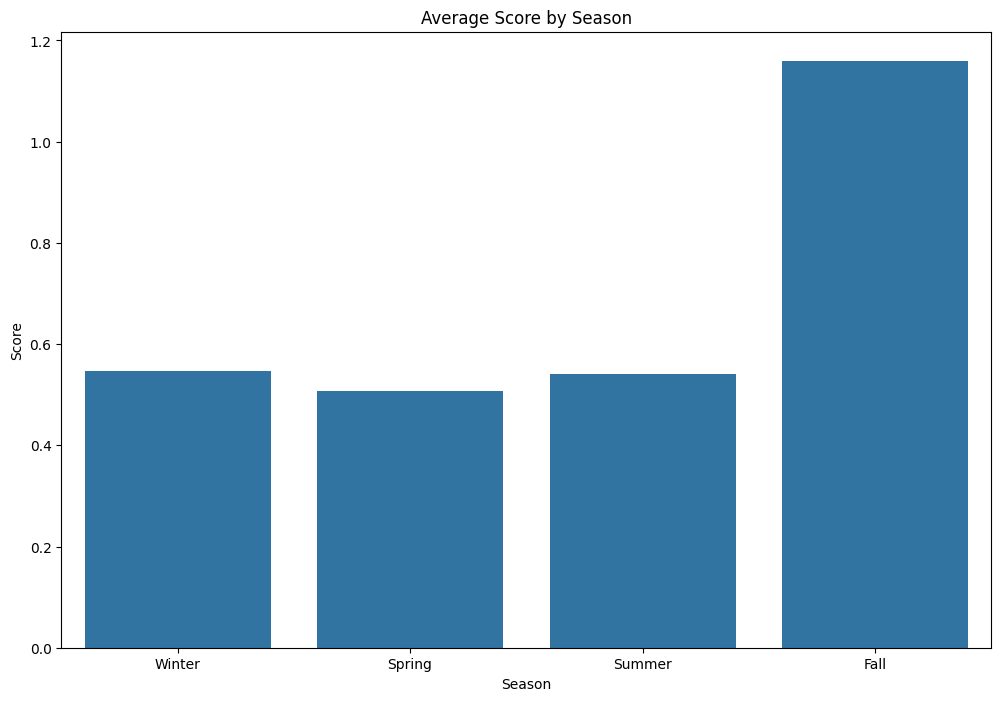

In [76]:
# Extract month from 'Review Date'
data_hotel_comments['Month'] = data_hotel_comments['Review Date'].dt.month

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data_hotel_comments['Season'] = data_hotel_comments['Month'].apply(get_season)

# Calculate average score by season
avg_score_by_season = data_hotel_comments.groupby('Season')['Score'].mean().reset_index()

# Plot the average score by season
plt.figure(figsize=(12, 8))
sns.barplot(data=avg_score_by_season, x='Season', y='Score', order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Average Score by Season')
plt.show()

Du khách đi du lịch Nha Trang nhiều nhất vao mùa thu, còn các mùa còn lại thì lượng khách tương đương nhau.

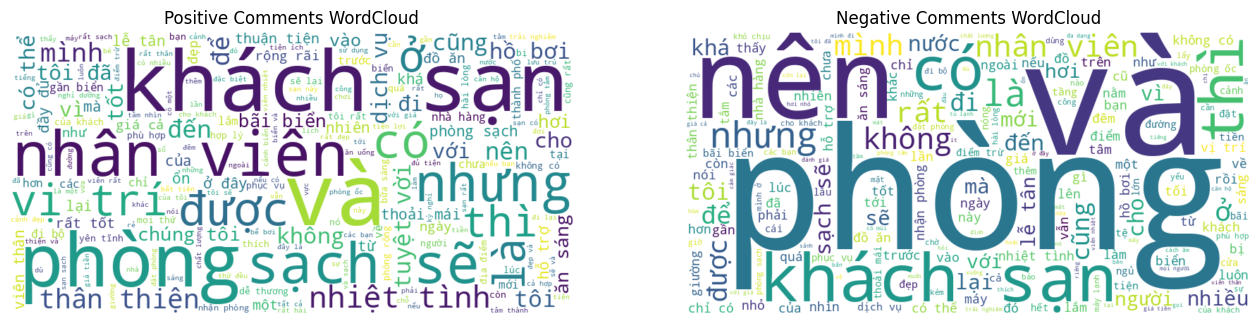

In [73]:
from wordcloud import WordCloud

# Generate word cloud for positive comments
positive_comments = ' '.join(data_hotel_comments[data_hotel_comments['Sentiment'] == 'positive']['Body'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_comments)

# Generate word cloud for negative comments
negative_comments = ' '.join(data_hotel_comments[data_hotel_comments['Sentiment'] == 'negative']['Body'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_comments)

# Plot word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Comments WordCloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Comments WordCloud')
plt.axis('off')

plt.show()

In [63]:
# Lọc dữ liệu cho sentiment positive và negative
positive_reviews = df_spark.filter(df_spark['Sentiment'] == 'positive').select('Body').rdd.flatMap(lambda x: x).collect()
negative_reviews = df_spark.filter(df_spark['Sentiment'] == 'negative').select('Body').rdd.flatMap(lambda x: x).collect()

In [64]:
from collections import Counter
import re

def count_words(text_list, words_list):
    # Kết hợp tất cả các văn bản thành một chuỗi
    combined_text = ' '.join(text_list).lower()

    # Đếm tần suất xuất hiện của các từ từ danh sách
    word_counts = Counter()
    for word in words_list:
        word_counts[word] = len(re.findall(r'\b' + re.escape(word) + r'\b', combined_text))

    return word_counts

# Đếm tần suất từ cho sentiment positive và negative
positive_word_counts = count_words(positive_reviews, positive_words)
negative_word_counts = count_words(negative_reviews, negative_words)

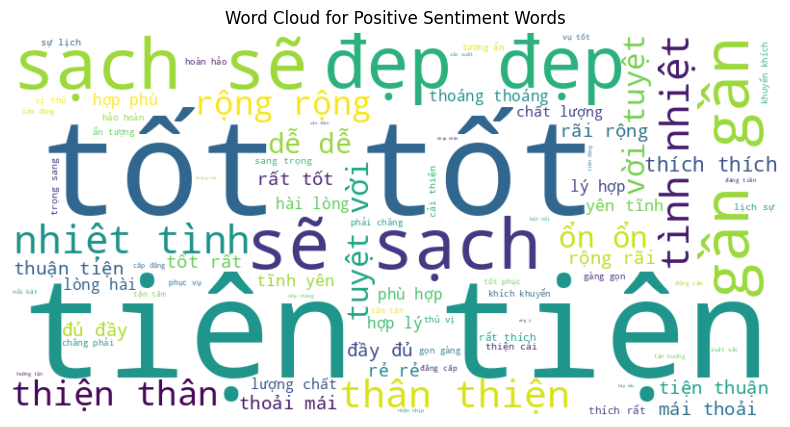

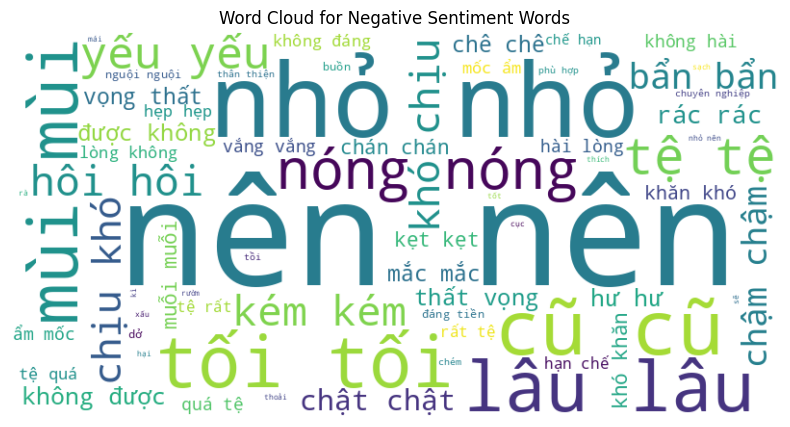

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(word_counts, title):
    # Tạo chuỗi văn bản cho word cloud
    text = ' '.join([f"{word} " * count for word, count in word_counts.items()])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Hiển thị word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Tạo word cloud cho các từ trong sentiment positive và negative
create_wordcloud(positive_word_counts, 'Word Cloud for Positive Sentiment Words')
create_wordcloud(negative_word_counts, 'Word Cloud for Negative Sentiment Words')

 Các phản hồi tích cực của khách hàng thường là phòng sạch sẽ, tiện, đẹp, phục vụ nhiệt tình.
 Còn các phản hồi tiêu cực thường là chê phòng nhỏ, tối, cũ, bẩn hôi, có thể là kèm theo phục vụ chậm, kém, tệ.

# 4.Xây dựng mô hình:

## a. Xây dựng mô hình trên sklearn

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(data_hotel_comments['Body'], data_hotel_comments['Sentiment'], test_size=0.2, random_state=42)

# Vector hóa dữ liệu văn bản
vectorizer = TfidfVectorizer(stop_words=stopwords_lst)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_vec, y_train)
y_pred_log_reg = log_reg.predict(X_test_vec)
log_reg_acc = accuracy_score(y_test, y_pred_log_reg)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)
rf_acc = accuracy_score(y_test, y_pred_rf)

# SVM
svm = SVC()
svm.fit(X_train_vec, y_train)
y_pred_svm = svm.predict(X_test_vec)
svm_acc = accuracy_score(y_test, y_pred_svm)

# So sánh hiệu suất
print("Logistic Regression Accuracy:", log_reg_acc)
print("Random Forest Accuracy:", rf_acc)
print("SVM Accuracy:", svm_acc)

# In báo cáo phân loại chi tiết
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

Logistic Regression Accuracy: 0.7457212713936431
Random Forest Accuracy: 0.7432762836185819
SVM Accuracy: 0.7603911980440098

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.49      0.60       100
     neutral       0.69      0.62      0.65       111
    positive       0.76      0.94      0.84       198

    accuracy                           0.75       409
   macro avg       0.74      0.69      0.70       409
weighted avg       0.75      0.75      0.73       409


Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.44      0.56       100
     neutral       0.80      0.62      0.70       111
    positive       0.72      0.96      0.82       198

    accuracy                           0.74       409
   macro avg       0.77      0.68      0.70       409
weighted avg       0.76      0.74      0.73       409


SVM Classification Report:
   

Dựa vào accuracy của ba mô hình Random Forest, Logistic Regression và SVM, Random Forest và SVM là cao nhất và là 76%. SVM có vẻ có sự cân bằng tốt hơn giữa các lớp và là sự lựa chọn tốt hơn trong trường hợp này.

## b. Xây dựng mô hình trên Pyspark

In [46]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=1a81114ce7554a4c4a479147c65becc58f96a4409be206ff9a68cafa3becb91d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [47]:
df_spark = spark.createDataFrame(data_hotel_comments)

In [48]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Tokenizer để chia cột 'Body' thành các từ
tokenizer = Tokenizer(inputCol="Body", outputCol="words")

# StopWordsRemover để loại bỏ các từ dừng
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# HashingTF để chuyển đổi từ thành các đặc trưng số
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features")

# IDF để tính trọng số TF-IDF
idf = IDF(inputCol="raw_features", outputCol="features")

# Chuyển đổi nhãn văn bản thành số
indexer = StringIndexer(inputCol="Sentiment", outputCol="label")

# Tạo pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashingTF, idf, indexer])

In [49]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
(train_data, test_data) = df_spark.randomSplit([0.8, 0.2], seed=1234)

In [50]:
from pyspark.ml.classification import LogisticRegression

# Định nghĩa mô hình Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Tạo pipeline cho Logistic Regression
pipeline_lr = Pipeline(stages=[tokenizer, stopwords_remover, hashingTF, idf, indexer, lr])

# Huấn luyện mô hình
model_lr = pipeline_lr.fit(train_data)

# Dự đoán trên tập kiểm tra
predictions_lr = model_lr.transform(test_data)

In [54]:
from pyspark.ml.classification import NaiveBayes

# Định nghĩa mô hình Naive Bayes
nb = NaiveBayes(featuresCol="features", labelCol="label")

# Tạo pipeline cho Naive Bayes
pipeline_nb = Pipeline(stages=[tokenizer, stopwords_remover, hashingTF, idf, indexer, nb])

# Huấn luyện mô hình
model_nb = pipeline_nb.fit(train_data)

# Dự đoán trên tập kiểm tra
predictions_nb = model_nb.transform(test_data)

predictions_lr.select("label", "rawPrediction", "probability", "prediction").show(truncate=False)

+-----+------------------------------------------------------------+-----------------------------------------------------------------+----------+
|label|rawPrediction                                               |probability                                                      |prediction|
+-----+------------------------------------------------------------+-----------------------------------------------------------------+----------+
|2.0  |[-55.13395490677229,-8.711098750286162,63.8450536570585]    |[2.1284973725248525E-52,3.085058341318149E-32,1.0]               |2.0       |
|2.0  |[-35.72239373867849,-67.50832692563758,103.23072066431607]  |[4.502245487956668E-61,7.062749226795769E-75,1.0]                |2.0       |
|0.0  |[93.6909852631305,-27.919110282243352,-65.77187498088713]   |[1.0,1.532521446694253E-53,5.5739071184572396E-70]               |0.0       |
|0.0  |[41.28465371966648,-9.853978365650978,-31.430675354015506]  |[1.0,6.176952664791612E-23,2.63107866825847E-32]        

In [59]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create an evaluator for multi-class classification
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Evaluate the model's accuracy
accuracy = evaluator.evaluate(predictions_lr)
print(f"Accuracy of Logistic Regression: {accuracy}")

# Evaluate other metrics
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions_lr)
print(f"Precision of Logistic Regression: {precision}")

recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions_lr)
print(f"Recall of Logistic Regression: {recall}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions_lr)
print(f"F1 Score of Logistic Regression: {f1_score}")

Accuracy of Logistic Regression: 0.7946210268948656
Precision of Logistic Regression: 0.8209015798749371
Recall of Logistic Regression: 0.7946210268948655
F1 Score of Logistic Regression: 0.8016080325973256


In [61]:
# Evaluate the model's accuracy
accuracy = evaluator.evaluate(predictions_nb)
print(f"Accuracy of Naive Bayes: {accuracy}")

# Evaluate other metrics
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions_nb)
print(f"Precision of Naive Bayes: {precision}")

recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions_nb)
print(f"Recall of Naive Bayes: {recall}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions_nb)
print(f"F1 Score of Naive Bayes: {f1_score}")

Accuracy of Naive Bayes: 0.6063569682151589
Precision of Naive Bayes: 0.6957992030316347
Recall of Naive Bayes: 0.6063569682151589
F1 Score of Naive Bayes: 0.5154670556857275


Nhận xét: Khi chạy trên Pyspark thì mô hình Logistic Regression thể hiện độ chính xác cao nhất.

In [66]:
data_hotel_comments.head(3)

,num,Hotel ID,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date,Positive Words Count,Negative Words Count,Sentiment
0,1,1_1,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,1,Trên cả tuyệt vời,Cao nhất‼︎”,tôi đã ở cùng chủ nhân đêm. nhân viên rất thân...,30/07/2023,2,1,positive
2,3,1_1,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,Đã ở 1 đêm vào Tháng 6 năm 2024,-1,Trên cả tuyệt vời,Du lịch tại Nha Trang”,lần này đến với tôi bok phòng tại khách sạn mư...,25/06/2024,1,2,negative
3,4,1_1,Việt Nam,Gia đình có em bé,Deluxe Hướng biển giường đôi,Đã ở 3 đêm vào Tháng 6 năm 2024,0,Tuyệt vời,Du lịch Nha Trang tại Mường Thanh”,hôm đi đến lúc về thì mọi thứ khách sạn điều t...,02/07/2024,1,1,neutral
